# Temporally Consistent Transformation VAE

In this notebook we experiment with autoencoders on a (very simple) transformation learning setup, with added emphasis on temporal consistency.

## Data

For this first experiment, we will generate images of a rotating arrow, for which we will try to find some interesting representation.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tfgraphviz as tfg
from tqdm import tqdm_notebook
import itertools
import sys
sys.path.append("../src")
import simulation 

## Experiment 1: Rotating Arrow

In [2]:
# We gather simulation
sim = simulation.RotatingArrowSimulation()

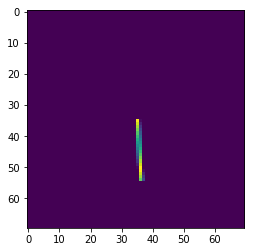

In [3]:
# We set sizes
im_size = 70
nb_samples = 500
# We instantiate the numpy array
X = sim.sample_trajectory([0.], [0.5], nb_samples).reshape([-1,im_size**2])
# We check that our function works expectedly
plt.imshow(X[10].reshape(im_size,im_size))
plt.show()

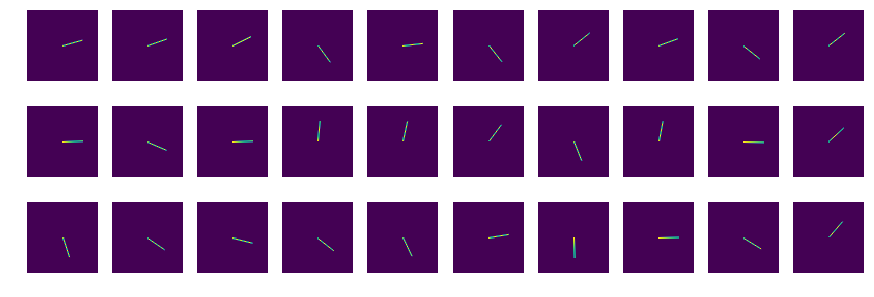

In [5]:
# We plot samples
fig, ax = plt.subplots(ncols=10, nrows=3,figsize=(15,5))
for x,y in itertools.product(range(3), range(10)):
    ax[x,y].imshow(X[np.random.randint(X.shape[0])].reshape(im_size, im_size))
    ax[x,y].axis('off')

In [6]:
# We instantiate the session
tf.reset_default_graph()
net_session = tf.InteractiveSession()

In [7]:
# We set the embedding size
emb_size = 2
# We set the data size
data_sz = im_size**2

In [8]:
# We set the network architecture
with tf.variable_scope("Input"):
    net_input = tf.placeholder(tf.float32, shape=[None,data_sz])
    net_now = net_input
    net_next = tf.placeholder(tf.float32, shape=[None,data_sz])
    
with tf.variable_scope("Encoder"):
    net_enc_w1 = tf.Variable(tf.truncated_normal([data_sz, 400], stddev=0.001))
    net_enc_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_enc_h1 = tf.nn.relu(tf.matmul(net_input, net_enc_w1) + net_enc_b1)
    
    net_enc_w2 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b2 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_mu = tf.matmul(net_enc_h1, net_enc_w2) + net_enc_b2
    
    net_enc_w3 = tf.Variable(tf.truncated_normal([400,emb_size], stddev=0.001))
    net_enc_b3 = tf.Variable(tf.constant(0., shape=[emb_size]))
    net_enc_log_var = tf.matmul(net_enc_h1, net_enc_w3) + net_enc_b3
        
with tf.variable_scope("Reparametrization"):
    net_rep_eps = tf.random_normal([emb_size])
    net_rep_mu = net_enc_mu
    net_rep_sigma = tf.exp(net_enc_log_var/2.)
    net_rep_z = net_enc_mu + tf.multiply(net_rep_eps, net_rep_sigma)
        
with tf.variable_scope("Now_Decoder"):
    net_now_dec_w1 = tf.Variable(tf.truncated_normal([emb_size, 400], stddev=0.001))
    net_now_dec_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_now_dec_h1 = tf.nn.relu(tf.matmul(net_rep_z, net_now_dec_w1) + net_now_dec_b1)
    
    net_now_dec_w2 = tf.Variable(tf.truncated_normal([400, data_sz], stddev=0.001))
    net_now_dec_b2 = tf.Variable(tf.constant(0., shape=[data_sz]))
    net_now_dec_h2 = tf.matmul(net_now_dec_h1, net_now_dec_w2) + net_now_dec_b2
    
    net_now_output = tf.nn.sigmoid(net_now_dec_h2)
    
with tf.variable_scope("Next_Decoder"):
    net_next_dec_w1 = tf.Variable(tf.truncated_normal([emb_size, 400], stddev=0.001))
    net_next_dec_b1 = tf.Variable(tf.constant(0., shape=[400]))
    net_next_dec_h1 = tf.nn.relu(tf.matmul(net_rep_z, net_next_dec_w1) + net_next_dec_b1)
    
    net_next_dec_w2 = tf.Variable(tf.truncated_normal([400, data_sz], stddev=0.001))
    net_next_dec_b2 = tf.Variable(tf.constant(0., shape=[data_sz]))
    net_next_dec_h2 = tf.matmul(net_next_dec_h1, net_next_dec_w2) + net_next_dec_b2
    
    net_next_output = tf.nn.sigmoid(net_next_dec_h2)
    
with tf.variable_scope("Loss/Optim"):
    net_loss_kld = 1 + net_enc_log_var - tf.square(net_enc_mu) - tf.exp(net_enc_log_var)
    net_loss_kld = - beta * 0.5 * tf.reduce_sum(net_loss_kld, reduction_indices=1)
    net_loss_now_lkh = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=net_now_dec_h2, labels=net_now), reduction_indices=1)
    net_loss_next_lkh = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=net_next_dec_h2, labels=net_next), reduction_indices=1)
    net_loss_loss = tf.reduce_mean(net_loss_kld + net_loss_now_lkh + net_loss_next_lkh)
    net_opt_step = tf.train.AdamOptimizer(0.001).minimize(net_loss_loss)
    

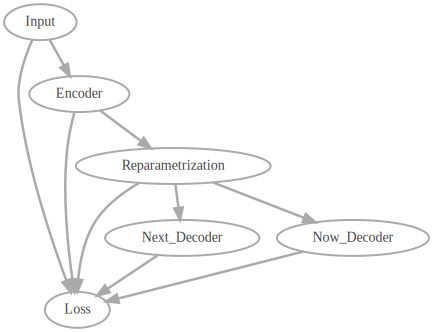

In [9]:
# We check the network
tfg.board(net_session.graph, depth=1)

In [10]:
# We initialize variables
net_session.run(tf.global_variables_initializer())

In [11]:
# We define epochs and batch size
epochs = int(1e4)
batch_size = 100
hist = np.zeros(epochs)
delta = 10
# We train the network with some batches
for i in tqdm_notebook(range(epochs),desc="Training network"):
    idx = np.random.permutation(X.shape[0]-delta)[:batch_size]
    feed_dict = {net_input:X[idx], net_next:X[idx+delta]}
    hist[i] = net_loss_loss.eval(feed_dict=feed_dict)
    net_opt_step.run(feed_dict=feed_dict)

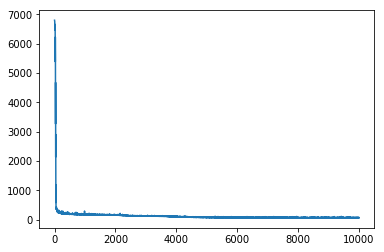

In [12]:
# We plot the learning curve
plt.plot(hist)
plt.show()

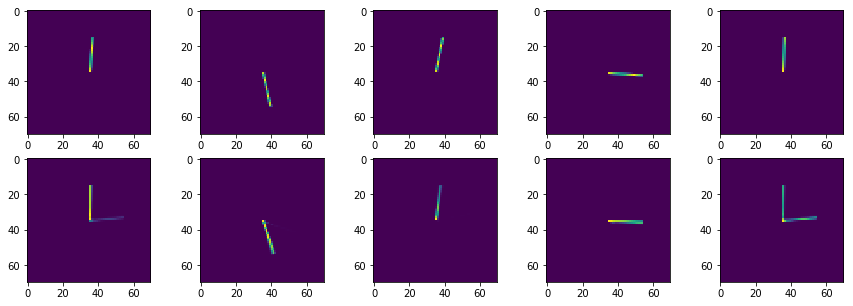

In [14]:
# We show reconstruction for some training samples
nb_draw = 5
idx = np.random.permutation(range(X.shape[0]))[0:nb_draw]
inpt = X[idx]
outpt = net_next_output.eval(feed_dict={net_input:inpt}) 
fig, ax = plt.subplots(ncols=nb_draw, nrows=2,figsize=(15,5))
for i in range(nb_draw):
    ax[0,i].imshow(inpt[i].reshape([im_size,im_size]))
    ax[1,i].imshow(outpt[i].reshape([im_size,im_size]))

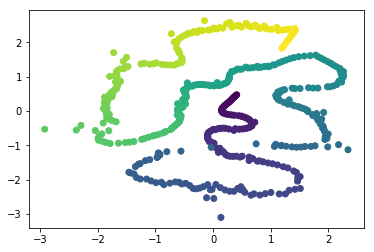

In [15]:
# We plot embedding variables evolution for rotating arrow
nb_draw = 10
inpt = X
emb = net_rep_mu.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]))